In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("email_spam_svm.csv")

In [3]:
df.head()

,word_freq_free,word_freq_money,word_freq_offer,email_length,is_spam
0,5.88,0.15,6.86,341.2,1
1,0.00,5.76,7.33,474.0,1
2,1.97,5.71,0.69,300.7,1
3,7.80,1.53,3.43,195.2,1
4,3.42,4.20,2.36,68.2,1


In [7]:
print("Missing values:\n", df.isnull().sum())


Missing values:
 word_freq_free     0
word_freq_money    0
word_freq_offer    0
email_length       0
is_spam            0
dtype: int64


In [28]:
print("Duplicates:", df.duplicated().sum())

Duplicates: 0


In [30]:
print("Data types:\n", df.dtypes)

Data types:
 word_freq_free     float64
word_freq_money    float64
word_freq_offer    float64
email_length       float64
is_spam              int64
dtype: object


In [32]:
print("\nData Summary:\n", df.describe())


Data Summary:
        word_freq_free  word_freq_money  word_freq_offer  email_length  \
count      150.000000       150.000000       150.000000    150.000000   
mean         5.376133         2.846800         3.844067    301.690000   
std          2.817702         1.640422         2.202354    128.771808   
min          0.000000         0.040000         0.030000     51.700000   
25%          3.210000         1.482500         1.977500    196.525000   
50%          5.710000         2.725000         3.970000    311.650000   
75%          7.730000         4.165000         5.460000    413.000000   
max          9.880000         5.960000         8.000000    498.200000   

          is_spam  
count  150.000000  
mean     0.973333  
std      0.161647  
min      0.000000  
25%      1.000000  
50%      1.000000  
75%      1.000000  
max      1.000000  


In [36]:
for col in ['word_freq_free', 'word_freq_money', 'word_freq_offer', 'email_length']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    print(f"{col}: {outliers} outliers")

word_freq_free: 0 outliers
word_freq_money: 0 outliers
word_freq_offer: 0 outliers
email_length: 0 outliers


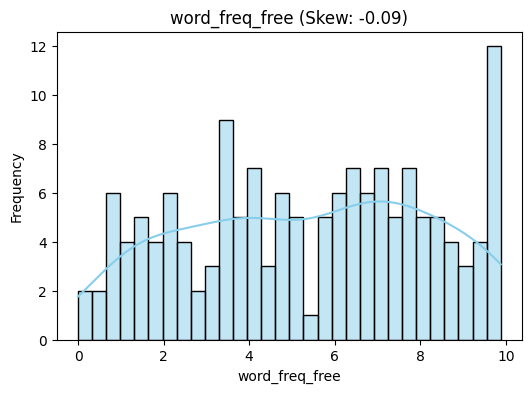

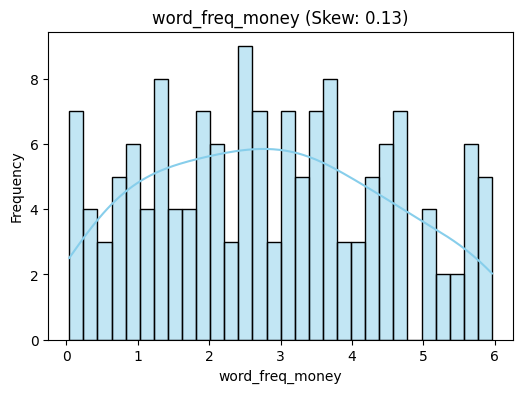

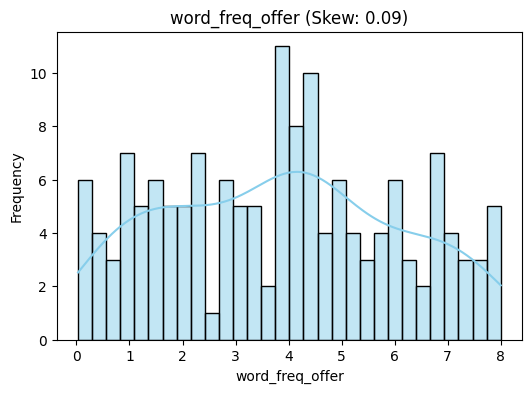

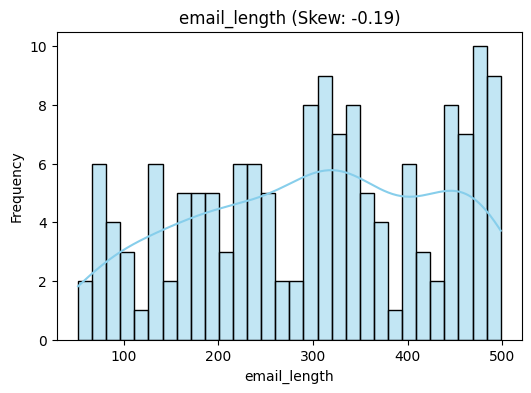

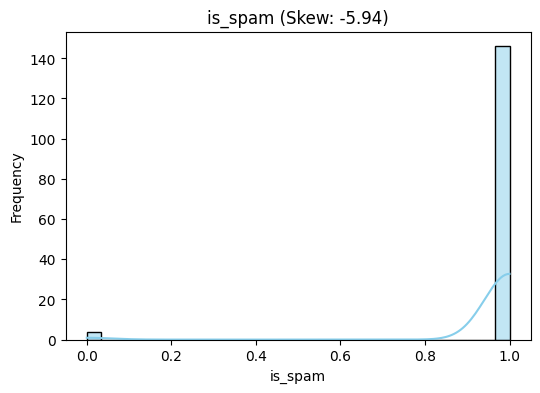

In [12]:
num_cols = df.select_dtypes(include='number').columns
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], bins=30, kde=True, color="skyblue")
    plt.title(f"{col} (Skew: {df[col].skew():.2f})")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


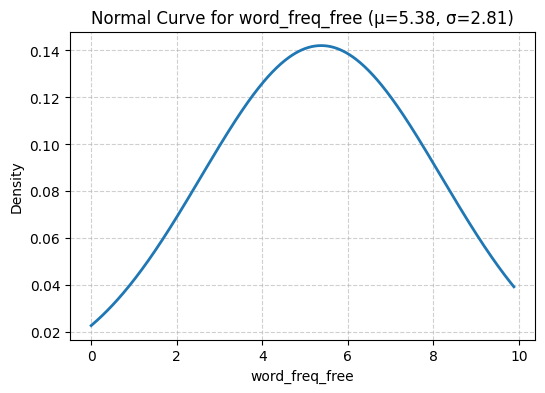

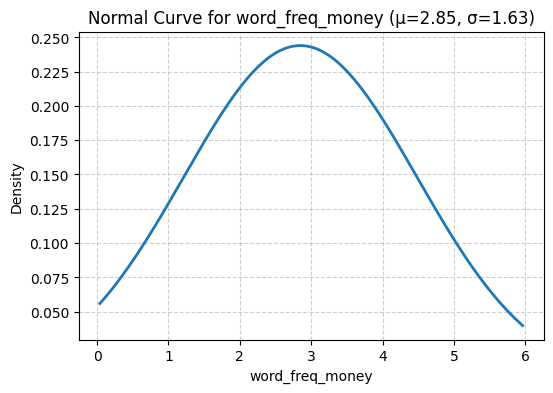

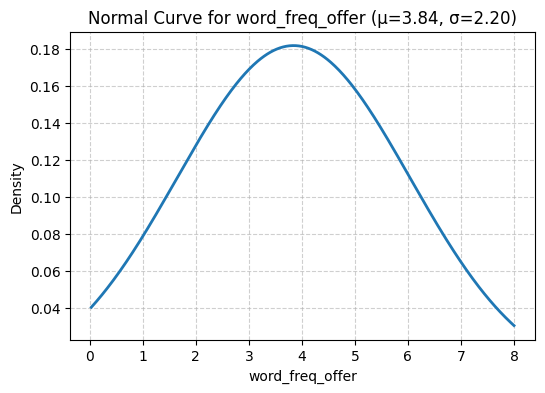

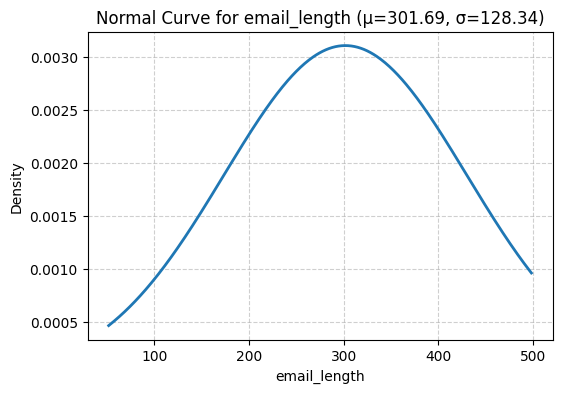

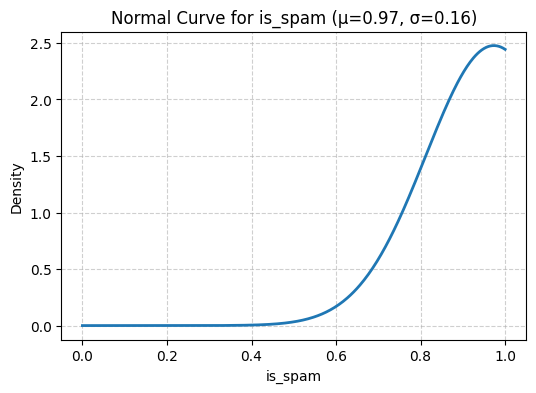

In [25]:
for col in num_cols:
    s = df[col].dropna().to_numpy()
    mu = s.mean()
    sigma = s.std(ddof=0)
    if sigma == 0 or np.isnan(sigma):
        continue
    x = np.linspace(s.min(), s.max(), 400)
    pdf = (1.0/(sigma*np.sqrt(2*np.pi))) * np.exp(-0.5*((x - mu)/sigma)**2)
    plt.figure(figsize=(6,4))
    plt.plot(x, pdf, linewidth=2)
    plt.title(f"Normal Curve for {col} (μ={mu:.2f}, σ={sigma:.2f})")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

In [39]:
X = df[['word_freq_free', 'word_freq_money', 'word_freq_offer', 'email_length']]
y = df['is_spam']

In [40]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [41]:
X_train, X_test, y_train, y_test = train_test_split( X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [42]:
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10]
    }

In [44]:
grid = GridSearchCV(SVC(probability=True), param_grid, cv=3, scoring='accuracy')
grid.fit(X_train, y_train)
best_model = grid.best_estimator_

In [46]:
cv_acc = cross_val_score(best_model, X_scaled, y, cv=3, scoring='accuracy').mean()
cv_auc = cross_val_score(best_model, X_scaled, y, cv=3, scoring='roc_auc').mean()

In [47]:
print("Best Params:", grid.best_params_)
print("CV Accuracy:", cv_acc)
print("CV ROC-AUC:", cv_auc)

Best Params: {'C': 0.1, 'kernel': 'linear'}
CV Accuracy: 0.9733333333333333
CV ROC-AUC: 0.9863945578231292


In [48]:
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

In [49]:
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_prob))

Test Accuracy: 0.9666666666666667
Test ROC-AUC: 1.0


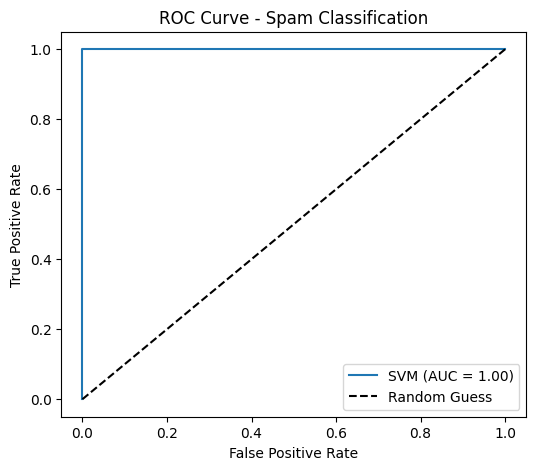

In [50]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"SVM (AUC = {roc_auc_score(y_test, y_prob):.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Spam Classification")
plt.legend()
plt.show()

In [51]:
new_email = [[2.1, 1.3, 0.7, 180]]
new_email_scaled = scaler.transform(new_email)
prediction = best_model.predict(new_email_scaled)
prob = best_model.predict_proba(new_email_scaled)[0, 1]

print(f"New Email Prediction: {'Spam' if prediction[0]==1 else 'Not Spam'} (Prob={prob:.2f})")

New Email Prediction: Spam (Prob=0.92)


d:\AI Workforce\SVM, Decision tree\task\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [53]:
import pickle
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svm = SVC(kernel='linear')
svm.fit(X, y)

with open("svm_model.pkl", "wb") as f:
    pickle.dump(svm, f)

print("Model saved as svm_model.pkl")


Model saved as svm_model.pkl
